#### Training ResNet50 on Chest CT-Scan images Dataset

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import gc

2025-04-29 06:15:18.299685: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 06:15:18.307805: I external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:469] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
I0000 00:00:1745903718.316953 4150111 cuda_dnn.cc:8703] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
I0000 00:00:1745903718.319664 4150111 cuda_blas.cc:1413] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745903718.327084 4150111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available and memory growth is set.")
else:
    print("No GPU found. Using CPU.")

GPU is available and memory growth is set.


In [3]:
DATA_DIR = "Data"
TRAIN_DATA_PATH = os.path.join(DATA_DIR, "train")
VALID_DATA_PATH = os.path.join(DATA_DIR, "valid")
TEST_DATA_PATH  = os.path.join(DATA_DIR, "test")
BATCH_SIZE      = 16
TARGET_SIZE     = (227,227)
INPUT_SHAPE     = [227,227,3]
EPOCHS          = 250

In [4]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=0.4
)
train_data = train_data_generator.flow_from_directory(
    TRAIN_DATA_PATH,
    batch_size=BATCH_SIZE,
    target_size=TARGET_SIZE,
    class_mode='categorical'
)

Found 613 images belonging to 4 classes.


In [5]:
validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
validation_data = validation_data_generator.flow_from_directory(
    VALID_DATA_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 72 images belonging to 4 classes.


In [6]:
class CNNModel:
    def __init__(self, input_shape=0, model_type='', model_path=None):
        self.model_type = model_type
        self.history = None
        self.history_accuracy = []
        self.history_val_accuracy = []
        self.history_loss = []
        self.history_val_loss = []
        self.input_shape = input_shape
        self.model = tf.keras.models.Sequential()
        self.model_path = model_path or 'savedModel/CNNModel.weights.h5'
        self.model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            self.model_path, save_weights_only=True, verbose=1)
        
    def fit(self, train_data, validation_data, epochs):
        self.history = self.model.fit(
            x=train_data, validation_data=validation_data,
            epochs=epochs, callbacks=[self.model_checkpoint]
        )
        self.history_accuracy.extend(self.history.history['accuracy'])
        self.history_val_accuracy.extend(self.history.history['val_accuracy'])
        self.history_loss.extend(self.history.history['loss'])
        self.history_val_loss.extend(self.history.history['val_loss'])

    def summary(self):
        return self.model.summary()
    def compareAccuracy(models):
        modelList = []
        for model in models:
            if model.history is not None:
                plt.plot(model.history_accuracy)
                modelList.append(model.model_type)
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

    def compareLoss(models):
        modelList = []
        for model in models:
            if model.history is not None:
                plt.plot(model.history_loss)
                modelList.append(model.model_type)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(modelList, loc='upper left')
        plt.show()

In [7]:
class ResNet(CNNModel):
    def __init__(self, input_shape=0, model_path='savedModel/ResNet.weights.h5'):
        super().__init__(input_shape=input_shape, model_type='ResNet', model_path=model_path)
        pretrained_model = tf.keras.applications.ResNet50(
            include_top=False, input_shape=INPUT_SHAPE, pooling='max', weights='imagenet')
        for layer in pretrained_model.layers:
            layer.trainable = True
        self.model.add(pretrained_model)
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(512, activation='relu'))
        self.model.add(tf.keras.layers.Dense(4, activation='softmax'))
        self.model.compile(
            loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy']
        )

In [8]:
resnet = ResNet(INPUT_SHAPE)

I0000 00:00:1745903720.058536 4150111 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6873 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0


In [9]:
resnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 24,585,732 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [10]:
resnet.fit(train_data, validation_data, EPOCHS)

Epoch 1/250


/home/ved/School/4DS/Data Science Project/code/Resnet50-CNN-Approach/.direnv/python-3.10.17/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-29 06:15:25.011624: I external/local_xla/xla/service/service.cc:152] XLA service 0x738a64016320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-29 06:15:25.011640: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0
2025-04-29 06:15:25.222896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:174

 1/39 ━━━━━━━━━━━━━━━━━━━━ 9:03 14s/step - accuracy: 0.5000 - loss: 5.2658

2025-04-29 06:15:35.334180: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_21', 44 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_12', 20 bytes spill stores, 44 bytes spill loads

I0000 00:00:1745903735.401451 4150723 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/39 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3682 - loss: 30.4742

2025-04-29 06:15:38.746671: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12625', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:15:38.762378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12632', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:15:39.054525: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12625', 708 bytes spill stores, 692 bytes spill loads

2025-04-29 06:15:39.089341: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12625', 848 bytes spill stores, 836 bytes spill loads

2025-04-29 06:15:39.312834: I extern

29/39 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - accuracy: 0.3720 - loss: 28.6148

2025-04-29 06:15:46.130182: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_9', 44 bytes spill stores, 48 bytes spill loads



39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.3789 - loss: 23.9533

2025-04-29 06:15:49.481730: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:15:49.858454: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:15:49.881771: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1726', 476 bytes spill stores, 484 bytes spill loads

2025-04-29 06:15:49.890387: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1719', 888 bytes spill stores, 876 bytes spill loads

2025-04-29 06:15:49.903934: I external/l


Epoch 1: saving model to savedModel/ResNet.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 427ms/step - accuracy: 0.3794 - loss: 23.5867 - val_accuracy: 0.2083 - val_loss: 62.4035
Epoch 2/250
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5592 - loss: 1.0279
Epoch 2: saving model to savedModel/ResNet.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5590 - loss: 1.0280 - val_accuracy: 0.2083 - val_loss: 8.8772
Epoch 3/250
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5326 - loss: 0.9929
Epoch 3: saving model to savedModel/ResNet.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.5330 - loss: 0.9925 - val_accuracy: 0.2083 - val_loss: 1.7456
Epoch 4/250
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5745 - loss: 0.9247
Epoch 4: saving model to savedModel/ResNet.weights.h5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.5743 - loss: 0.9246 - val_accuracy: 0.2361 - val_loss: 1.6073
Epoch 5/250
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc

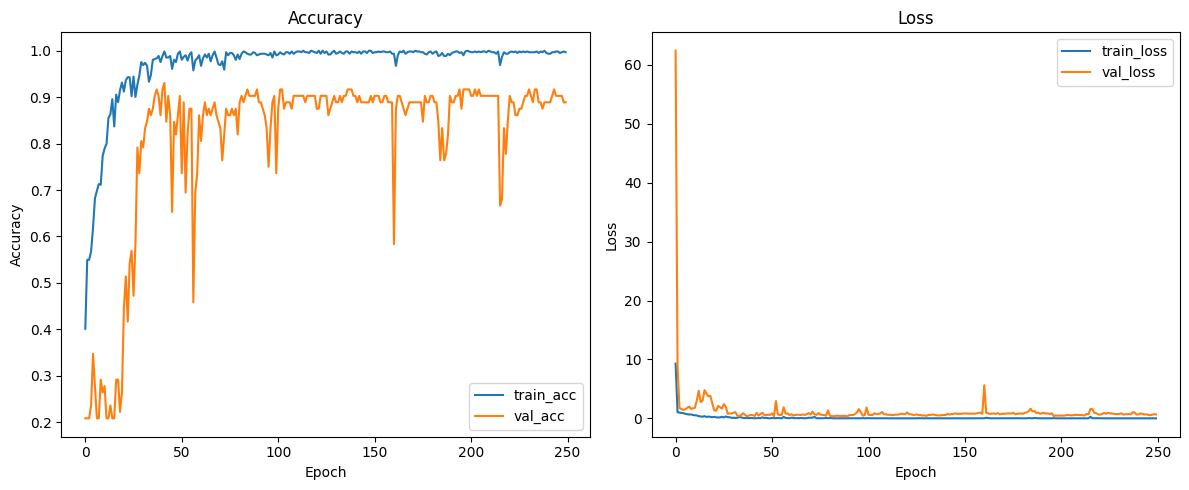

In [ ]:
import matplotlib.pyplot as plt

hist = resnet.history.history

plt.figure(figsize=(12,5))

# accuracy
plt.subplot(1,2,1)
plt.plot(hist['accuracy'],   label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1,2,2)
plt.plot(hist['loss'],      label='train_loss')
plt.plot(hist['val_loss'],  label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Evaluation Details

In [11]:
# Prepare test set (no shuffling)
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_data = test_data_generator.flow_from_directory(
    TEST_DATA_PATH,
    target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

Found 315 images belonging to 4 classes.


17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

2025-04-29 06:30:15.597596: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1676', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:30:15.896395: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1683', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:30:15.917482: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1683', 476 bytes spill stores, 484 bytes spill loads

2025-04-29 06:30:15.966997: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1683', 8 bytes spill stores, 8 bytes spill loads

2025-04-29 06:30:16.004417: I external/local

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step
ResNet Classification Report
                         precision    recall  f1-score   support

         adenocarcinoma       0.94      0.93      0.93       120
   large.cell.carcinoma       0.89      0.98      0.93        51
                 normal       1.00      1.00      1.00        54
squamous.cell.carcinoma       0.97      0.93      0.95        90

               accuracy                           0.95       315
              macro avg       0.95      0.96      0.95       315
           weighted avg       0.95      0.95      0.95       315



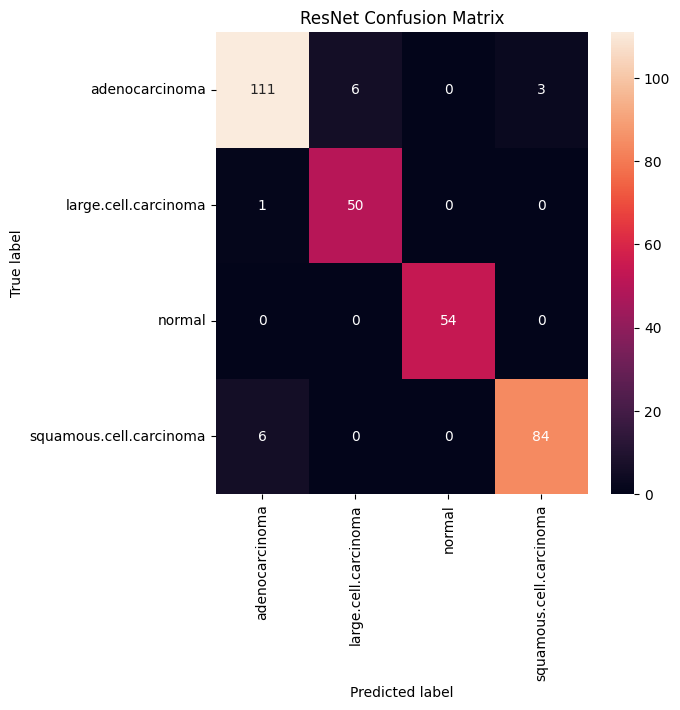

In [12]:
# ResNet Evaluation
pred = resnet.model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
print('ResNet Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))
cm_hybrid = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()